In [2]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Replace 'your_file.json' with your JSON file's name
file_metadata = "../data/gpt4_on_metadata.json"
file_ncml = "../data/gpt4_on_ncml.json"

sns.set_style("whitegrid")
figsize = (4, 3)
sns.set_palette("bright")

# Set the font family
plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams["font.size"] = 12
sns.set_context("paper") #, font_scale=2)

In [3]:
var_dict2 = {}

In [4]:

with open(file_ncml, "r") as file:
    metadata = json.load(file)

var_dict = {}
for dataset in metadata.keys():
    if metadata[dataset].get("response"):
        metadata[dataset] = metadata[dataset]["response"]
    else:
        metadata[dataset] = {}
        continue

    variable_names = metadata[dataset].get("variable_names", [])
    var_dict[dataset] = {}
    var_dict[dataset] = variable_names

    key = dataset.split("_")[1].split(".")[0]
    if key not in var_dict2:
        var_dict2[key] = {}
    var_dict2[key]["ncml"] = variable_names

In [5]:
for var in var_dict2:
    if ("metadata" in var_dict2[var]) and ("ncml" in var_dict2[var]):
        print(var_dict2[var])

In [6]:
var_names = []
for var in var_dict.keys():
    if len(var_dict[var]) ==0:
        continue
    if var_dict[var][0].get('name'): 
        var_names.append(var_dict[var][0]['name'].lower())
        #print(var_dict[var][0]['name'])

In [7]:
from collections import Counter
element_count = Counter(var_names)

print(element_count)

Counter({'granule': 20, 'time': 15, 'lon': 13, 'longitude': 11, 'lat': 9, 'x': 3, 'isrf': 2, 'i1': 1, 'source_id': 1, 'rx1day_ann': 1, 'london_so2_annual_tg': 1, 'drycoeff': 1, 'area': 1, 'model': 1, 'vavg_hox': 1, 'image': 1, 'u': 1, 'radiance_out': 1, 'latitude': 1, 'mapdata': 1, 'o3': 1, 'ftir_daily_simple_vcd_noak': 1, 'precipitationcal': 1, 'chl_oc4me': 1, 'precc': 1, 'longitude_t': 1, 'scenes': 1, 'h': 1, 'px': 1, 'olr': 1, 'prect': 1, 'precip': 1, 'land': 1, 'group_lon': 1, 'pres_diff_09': 1, 'fxlat': 1, 'maxgrpdis': 1, 'landmask': 1, 'pwv': 1, 'mean_radiance': 1, 'weh': 1, 'myd08_d3_6_1_aod_550_dark_target_deep_blue_combined_mean': 1, 'aodvisstdn': 1, 'diurnal': 1, 'month': 1, 'effectiveoht': 1, 'dust_jday': 1, 'carbonbiomass': 1, 'blocks': 1, 'z200_jja': 1, 'hour': 1, 'initial_time': 1, 'station': 1, 'cld': 1, 'precip_acc6h': 1, 'prof_depth': 1, 'isen': 1, 'year': 1, 'oceqnet': 1})


In [8]:
def process_json_file(file_name):
    with open(file_name, "r") as file:
        metadata = json.load(file)

    for dataset in metadata.keys():
        if metadata[dataset].get("response"):
            metadata[dataset] = metadata[dataset]["response"]
        else:
            metadata[dataset] = {}
            continue

        name_count, unit_count = 0, 0
        variable_names = metadata[dataset].get("variable_names", [])
        for variable in variable_names:
            if variable["name"]: # is not None:
                name_count += 1
            if variable["unit"]: # is not None:
                unit_count += 1

        metadata[dataset]["variable_names"] = name_count if name_count > 0 else None
        metadata[dataset]["variable_units"] = unit_count if unit_count > 0 else None

        data_sources = metadata[dataset].get("data_sources", [])
        if len(data_sources) > 0:
            metadata[dataset]["data_sources"] = ', '.join(data_sources)
        else:
            metadata[dataset]["data_sources"] = None

        software = metadata[dataset].get("software", [])
        if len(software) > 0:
            metadata[dataset]["software"] = ', '.join(software)
        else:
            metadata[dataset]["software"] = None

        temporal_coverage = metadata[dataset].get("temporal_coverage", {})
        if temporal_coverage:
            if temporal_coverage["start"] is not None:
                metadata[dataset]["start"] = temporal_coverage["start"]
            if temporal_coverage["end"] is not None:
                metadata[dataset]["end"] = temporal_coverage["end"]

        spatial_coverage = metadata[dataset].get("spatial_coverage", {})
        if spatial_coverage:
            for key in [
                "coordinates",
                "bounding_box",
                "locations",
                "longitude",
                "latitude",
                "start_location",
                "end_location",
            ]:
                if spatial_coverage.get(key):
                    metadata[dataset][key] = spatial_coverage[key]
                    if key == "locations":
                        metadata[dataset]["locations"] = ', '.join(spatial_coverage[key])

        accuracy_issues = metadata[dataset].get("accuracy_issues", {})
        if accuracy_issues:
            if accuracy_issues.get("known_inaccuracies"):
                metadata[dataset]["known_inaccuracies"] = accuracy_issues.get(
                    "known_inaccuracies"
                )
            if accuracy_issues.get("missing_values"):
                metadata[dataset]["missing_values"] = accuracy_issues.get(
                    "missing_values"
                )

    df = pd.DataFrame(metadata)

    # fill nan
    # df = df.fillna(0)
    # replace [] with 0
    df = df.replace([], None)
    df = df.replace({}, None)

    df = df.transpose()

    df = df.reset_index()
    df["id"] = df["index"].apply(lambda x: x.split("_")[1].split(".")[0])
    df = df.drop(
        columns=["temporal_coverage", "spatial_coverage", "accuracy_issues", "index"]
    )

    return df

# df = df.applymap(lambda x: 0 if (x == []) else x)
# df = df.applymap(lambda x: 0 if (x == {}) else x)

# # replace text with 1
# df = df.applymap(lambda x: 1 if isinstance(x, list) else x)
# df = df.applymap(lambda x: 1 if isinstance(x, dict) else x)

In [9]:
metadata_df = process_json_file(file_metadata)

In [10]:
ncml_df = process_json_file(file_ncml)

In [11]:
ncml_df["type"] = "ncml"
metadata_df["type"] = "metadata"

In [12]:
df = pd.concat([metadata_df, ncml_df], axis=0)
# df = ncml_df.merge(metadata_df, on="id", how="left", suffixes=("_ncml", "_metadata"))

In [13]:
len(metadata_df), len(ncml_df), len(df)

(134, 134, 268)

In [14]:
df.variable_names

0        1
1        5
2      NaN
3        1
4        1
      ... 
129      1
130      6
131      3
132    NaN
133      6
Name: variable_names, Length: 268, dtype: object

## Data Cleaning

In [15]:
# Clean and standardize the column

# Notes:
# 'epsg:4326': This is a common EPSG (European Petroleum Survey Group) code for the WGS84 coordinate system. It's essentially a formal reference to WGS84.
# 'ecco4r5': Although it's not an official abbreviation for WGS84, it seems to be a variation or a typo of "ECCOv4r5," which could be a reference to a specific dataset or implementation of the WGS84 system.
# 'degrees': The term "degrees" is often associated with latitude and longitude measurements in the WGS84 coordinate system. While it's not the full name, it's a common way to informally refer to it.
# 'longitude and latitude', 'degree', 'lat/lon', 'lon, lat', 'lon/lat', 'degrees_north, degrees_east', 'degrees_east, degrees_north': These are all descriptions or representations of latitude and longitude, which are characteristic of the WGS84 coordinate system. Variations in the way these terms are expressed don't change the underlying reference to WGS84.

df['coordinate_system'] = df['coordinate_system'].str.lower()  # Step 1: Convert to lowercase

# Step 2: Replace variations with standard values
df['coordinate_system'].replace({
    'epsg:4326': 'wgs84',
    'eccov4r5': 'wgs84',
    'degrees': 'wgs84',
    'longitude and latitude': 'wgs84',
    'degree': 'wgs84',
    'lat/lon': 'wgs84',
    'lon, lat': 'wgs84',
    'lon/lat': 'wgs84',
    'degrees_north, degrees_east': 'wgs84',
    'degrees_east, degrees_north': 'wgs84',
    'unspecified': None,  
    'center-of-mass (cm) and center-of-figure (cf) reference frames': 'other'
}, inplace=True)

df.coordinate_system.value_counts()

/var/folders/lc/q1l1y0k176b0h_m5yz0s_r5w0000gn/T/ipykernel_48762/3652621899.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['coordinate_system'].replace({


coordinate_system
wgs84    28
other     1
Name: count, dtype: int64

In [16]:
df[df.coordinate_system.notnull()][["id", "coordinate_system"]].sort_values(by="id")

,id,coordinate_system
52,2842848,wgs84
73,2904219,wgs84
75,3349351,wgs84
53,3364353,wgs84
59,3417267,other
58,3621191,wgs84
28,3849458,wgs84
44,3986102,wgs84
63,4491248,wgs84
36,4499596,wgs84


In [17]:
"""
For variations of "CF" (Climate and Forecast conventions) such as "CF-1.6," "CF-1.0," and "CF-1.7," they were all mapped to "CF" because they are different versions or extensions of the same convention.
For variations of "netCDF-4" (Network Common Data Form version 4), such as "netcdf," "http://www.unidata.ucar.edu/namespaces/netcdf/ncml-2.2," "coards," "hdf," and "netcdf4-cf," they were mapped to "netCDF-4" because they are related to this specific data format.
Values like "wgs84," "Community Emissions Data System (CEDS)," "IPCC," and "CESM" were mapped to "unknown" because they don't appear to be conventions related to data formats and may not fit the same category as the others.
"CF-1.0, + local extensions" was mapped to "CF" because it's primarily related to the CF convention, and the "local extensions" part is specific details that can be analyzed separately if needed.
"""

# Clean and standardize the column
df['convention'] = df['convention'].str.lower()  # Step 1: Convert to lowercase

# Step 2: Replace variations with standard values
df['convention'].replace({
    'cf-1.4': 'cf',
    'cf-1.6': 'cf',
    'cf-1.0': 'cf',
    'netcdf': 'cf',
    'http://www.unidata.ucar.edu/namespaces/netcdf/ncml-2.2': 'cf',
    'coards': 'cf',
    'hdf': 'cf',
    'netcdf4-cf': 'cf',
    'netcdf4': 'cf',
    'netcdf-4': 'cf',
    'cf-1.7': 'cf',
    'netcdf markup language / ncml-2.2': 'cf',
    'wgs84': None,
    'aqua granule hdf': 'cf',
    '+init=epsg:4326': None,
    'community emissions data system (ceds)': None,
    'ipcc': None,
    'cesm': None,
    'cf-1.0, + local extensions': 'cf'
}, inplace=True)

df.convention.value_counts()

/var/folders/lc/q1l1y0k176b0h_m5yz0s_r5w0000gn/T/ipykernel_48762/3605779381.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['convention'].replace({


convention
cf    88
Name: count, dtype: int64

In [18]:
df.start_location.value_counts()

start_location
Laki, Iceland     1
LON_RHO152_152    1
Name: count, dtype: int64

In [19]:
# move start_location and end_location to locations
# remove start_location and end_location

mask = ~df["end_location"].isnull()
df.loc[mask, "locations"] = df.loc[mask, "end_location"]

mask = ~df["start_location"].isnull()
df.loc[mask, "locations"] = df.loc[mask, "start_location"]

#df[~df["start_location"].isnull()][["start_location", "locations"]]

df = df.drop(columns=["start_location", "end_location"])

In [20]:
# merge coordinates and bounding_box ?
# and lon and lat ?

mask = ~df["coordinates"].isnull() & df["bounding_box"].isnull()
df.loc[mask, "bounding_box"] = df.loc[mask, "coordinates"]

df[~df["coordinates"].isnull()][["coordinates", "bounding_box"]]

df = df.drop(columns=["coordinates"])

In [21]:
def get_bounding_box(row):
    """ Combine longitude and latitude into bounding_box """
    if row['bounding_box']:
        return row['bounding_box']
    if row['latitude'] and row['longitude']:
        if len(row['latitude'])==2 and len(row['longitude'])==2:
            return [row['latitude'][0], row['longitude'][0], row['latitude'][1], row['longitude'][1]]
        if len(row['latitude'])==1 and len(row['longitude'])==1:
            return [row['latitude'][0], row['longitude'][0]]
        return [row['latitude'][0], row['longitude'][0], row['latitude'][-1], row['longitude'][-1]]
    if row['latitude']:
        return row['latitude']
    return row['longitude']

df = df.where(pd.notna(df), None)
df['bounding_box'] = df.apply(get_bounding_box, axis=1)

df = df.drop(columns=["latitude", "longitude"])

# df[~df["latitude"].isnull()][["latitude", "longitude", "bounding_box"]]

In [22]:
df['software'].replace({
    'unknown': None,
    'Not Specified': None,
}, inplace=True)

df.software.value_counts()

/var/folders/lc/q1l1y0k176b0h_m5yz0s_r5w0000gn/T/ipykernel_48762/2813909633.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['software'].replace({


software
netcdf=4.6.2, hdf5=1.10.4                                                                          9
NetCDF Markup Language                                                                             3
Python v3.8                                                                                        2
Aqua granule hdf                                                                                   2
version=2, netcdf=4.6.2, hdf5=1.10.4                                                               2
                                                                                                  ..
Model output for Dutkiewicz et al (BGD): nurtient_supply_rates.nc, biomass.nc                      1
Vulcan version 3.0, gridded inventory of CH4 emissions                                             1
WACCM, Reproducing_Figures_Linzetal2021_AoA.m                                                      1
Gaofen5, ZY1, PRISMA                                                              

In [23]:
for sw in df.software.unique():
    if sw:
        print(sw)

SAGE-IGP
DART, CESM2 Ocean Component
CESM
EC-Earth v3.3.1, netcdf, LPJ-GUESS_
simulation software
ECCOv4r5
codes used in our paper
CESM Version 2, CESM2, netCDF4
WRF
MRCM
STILT model
Community Earth System Model (CESM)
Original Processing Code
Aqua granule hdf
DNS
CESM1(WACCM)
CM1 model
Code to calculate impacts & produce figures/tables
GRACE, ECMWF, TPXO 7.2, CMEMS, SPOTL, ICE-5G
CESM2, MAECHAM5-HAM, SOCOL-AERv2
WRF-Fire
Machine Learning Pipeline
CMIP6 ensemble
CSR, GFZ, JPL
Aqua
Docker
Matlab
Python v3.8
https://github.com/natgeo-wong/2023GL104350
codes, datasets
SINTEX-F GCM
Gaofen5, ZY1, PRISMA
WACCM, Reproducing_Figures_Linzetal2021_AoA.m
SOCOL-AER
Vulcan version 3.0, gridded inventory of CH4 emissions
Model output for Dutkiewicz et al (BGD): nurtient_supply_rates.nc, biomass.nc
MATLAB 2022a version, MITgcm
Custom code
CMAQ
Community Earth System Model (CESM version 1.2.2)
NetCDF, GitHub
sample codes
Aqua Granule
ECCO v4 ocean state estimate, release 2
version=2, netcdf=4.7.3, hdf

In [24]:
df['data_sources'].replace({
    'Unknown': None,
    'unspecified': None,
    'file:': None,
    'unknown': None,
    'Unspecified': None,
    'Harvard Dataverse': None,
    'Publications': None,
    'Yu Gao': None,
    'Replication Data': None,
}, inplace=True)

df.data_sources.value_counts()

/var/folders/lc/q1l1y0k176b0h_m5yz0s_r5w0000gn/T/ipykernel_48762/3193658702.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['data_sources'].replace({


data_sources
Aqua satellite, MODIS Collection 6.1                                                                                    15
Max-Planck-Institute for Meteorology                                                                                     2
Streets et al. (2019), Zhang et al. (2016)                                                                               1
ECCO consortium (http://ecco-group.org/), MIT                                                                            1
Constraining extreme precipitation projections using past precipitation variability                                      1
                                                                                                                        ..
Multidecadal changes in zonal displacement of tropical Pacific MJO variability modulated by North Atlantic SST paper     1
Argo float network                                                                                                       1
Dig

In [25]:
for sw in df.data_sources.unique():
    if sw:
        print(sw)

Forget, G. and Ferreira, D., Nature Geoscience
Survey Constraints on FRP-based AGricultural Fire Emissions in the Indo-Gangetic Plain
LA-UR-20-25866
JAMES
Feinberg et al. (2022): Evaluating atmospheric mercury (Hg) uptake by vegetation in a chemistry-transport model, Environmental Science: Processes & Impacts, https://doi.org/10.1039/D2EM00032F
Various source providers
2023 Earth Energy Imbalance Assessment Workshop
OCCA atlas
kricke@ucsd.edu
Bonilla et al. (2023), Environmental Research: Health
Quantifying methane emissions from the largest oil-producing basin in the United States from space
Gao Y, Liu Z, Lu Z, 2020, Dynamic Effect of Last Glacial Maximum Ice Sheet Topography on East Asian Summer Monsoon, Journal of Climate
2022 Princeton AOS workshop
Improved simulation of 19th and 20th-century North Atlantic hurricane frequency after correcting historical sea surface temperatures
Influence of large-scale climate patterns on summertime U.S. ozone: A seasonal predictive model for air 

In [26]:
len(df[~df.data_sources.isnull()])

132

In [27]:
len(df[~df.data_collection_method.isnull()])

72

In [28]:
df[pd.notna(df.data_sources) & pd.notna(df.data_collection_method)][['data_sources', 'data_collection_method']]

,data_sources,data_collection_method
1,Survey Constraints on FRP-based AGricultural F...,"Satellite Observations, Household Survey Respo..."
7,Feinberg et al. (2022): Evaluating atmospheric...,Model Simulation
8,Various source providers,"Various methods including gauge-based, satelli..."
9,2023 Earth Energy Imbalance Assessment Workshop,ECCOv4r5 model simulation
10,OCCA atlas,"sensor readings, satellite"
24,"MPI-ESM1-2-LR, HadGEM3-GC31-LL, NorESM2-LM",MRCM simulation
28,MethaneAIR instrument,Instrument readings
30,Emma Hill,GPS
36,"CloudSat, CALIPSO, GOES-16 ABI, GFS",sensor readings
46,"Lu et al. (2018, JGR)",model analysis


In [29]:
df['data_collection_method'].value_counts()

data_collection_method
Aqua satellite, MODIS Collection 6.1                                                                                                           12
Satellite                                                                                                                                       6
sensor readings                                                                                                                                 3
satellite                                                                                                                                       2
ship-track                                                                                                                                      2
Derived from granule name                                                                                                                       2
McLane moored profiler (MP) data                                                                     

In [30]:
df["start"] = df["start"].apply(lambda x: x[:4] if x else x)

In [31]:
df["end"] = df["end"].apply(lambda x: x[:4] if x else x)

In [32]:
print(df[df.end.notnull()]["end"])

1      2018
10     2006
13     2012
23     2021
24     2050
       ... 
89     2007
92     2014
99     2012
107    2018
111    2020
Name: end, Length: 68, dtype: object


In [33]:
def get_temporal_coverage(row):
    if row["start"] and row["end"]:
        if row["start"] < row["end"]:
            return row["start"] + " - " + row["end"]
    elif row["start"]:
        return row["start"]
    elif row["end"]:
        return row["end"]
    else:
        return None

df["temporal_coverage"] = df[["start", "end"]].apply(get_temporal_coverage, axis=1)
df.drop(columns=["start", "end"], inplace=True)

In [34]:
df.drop(columns=["time_frequency", "spatial_resolution"], inplace=True)

# not descriptive

In [35]:
df.bounding_box.value_counts()

bounding_box
[-180.0, -60.0, 180.0, 60.0]              14
[-60.0, -180.0, 60.0, 180.0]               4
[-90.0, 0.0, 90.0, 360.0]                  3
[192.0, 288.0]                             2
[72.0, 144.0]                              2
[71.0, -79.0, 20.75, -64.2]                1
[162.0, 97.0]                              1
[-84.375, -56.1182, -33.0469, 14.8975]     1
[0.0, -90.0, 359.0, 90.0]                  1
[0.0, 180.0, -90.0, 90.0]                  1
[1345.0, 2880.0]                           1
[361.0, 720.0]                             1
[-180.0, 180.0, -60.0, 60.0]               1
[360.0, 160.0, 50.0, 12.0]                 1
[-98.6552, 19.1187]                        1
[-180.0, -90.0, 180.0, 90.0]               1
[48.0, 96.0]                               1
[33.0, 33.0]                               1
[88.0, -88.0]                              1
[519665.0, 4768505.0]                      1
[160.0, 360.0]                             1
[0.0, 0.0, 87.0, 91.0]                    

In [36]:
df.data_sources.value_counts()

data_sources
Aqua satellite, MODIS Collection 6.1                                                                                    15
Max-Planck-Institute for Meteorology                                                                                     2
Streets et al. (2019), Zhang et al. (2016)                                                                               1
ECCO consortium (http://ecco-group.org/), MIT                                                                            1
Constraining extreme precipitation projections using past precipitation variability                                      1
                                                                                                                        ..
Multidecadal changes in zonal displacement of tropical Pacific MJO variability modulated by North Atlantic SST paper     1
Argo float network                                                                                                       1
Dig

In [37]:
df.timestamp_format.value_counts()

timestamp_format
ISO 8601                               10
UNIX                                    2
proleptic_gregorian                     2
derived from granule name               1
days since 2001-01-01 00:00:00.0        1
days since                              1
Y-m-d\TH:i:s\Z                          1
days since 1-01-01 00:00:00             1
hours since 1900-01-01 00:00:0.0        1
YYYY-MM-DDThh:mm:ss.ssssss              1
days since 1970-01-01 00:00             1
days since 0001-01-01 00:00:00          1
hours since 2010-10-01                  1
YYYYMMDDHH                              1
seconds since 1990-01-01 00:00:00       1
hours since 1900-1-1 00:00:00           1
days since 1750-12-31                   1
seconds since 1970-01-01 00:00:00.0     1
YYYY-MM-DD HH:MM:SS                     1
YYYY                                    1
Derived from Granule Name               1
YYMMDDHHMM                              1
hours since 1800-01-01 00:00:0.0        1
Name: count, dtyp

In [38]:
['known_inaccuracies', 'missing_values', ],

(['known_inaccuracies', 'missing_values'],)

## Plots

In [39]:
len(df)

268

In [40]:
df.head()

,variable_names,data_sources,variable_units,software,convention,coordinate_system,timestamp_format,data_collection_method,locations,known_inaccuracies,missing_values,id,type,bounding_box,temporal_coverage
0,1,"Forget, G. and Ferreira, D., Nature Geoscience",None,None,None,None,None,None,None,None,None,3465866,metadata,None,None
1,5,Survey Constraints on FRP-based AGricultural F...,None,SAGE-IGP,None,None,None,"Satellite Observations, Household Survey Respo...","Punjab, Haryana, Uttar Pradesh, Bihar",None,None,4079670,metadata,None,2003 - 2018
2,None,None,None,None,None,None,None,None,None,None,None,2845786,metadata,None,None
3,1,LA-UR-20-25866,None,None,None,None,None,None,None,None,None,4101125,metadata,None,None
4,1,JAMES,None,"DART, CESM2 Ocean Component",None,None,None,None,None,None,None,4098599,metadata,None,None


In [41]:
df.columns

Index(['variable_names', 'data_sources', 'variable_units', 'software',
       'convention', 'coordinate_system', 'timestamp_format',
       'data_collection_method', 'locations', 'known_inaccuracies',
       'missing_values', 'id', 'type', 'bounding_box', 'temporal_coverage'],
      dtype='object')

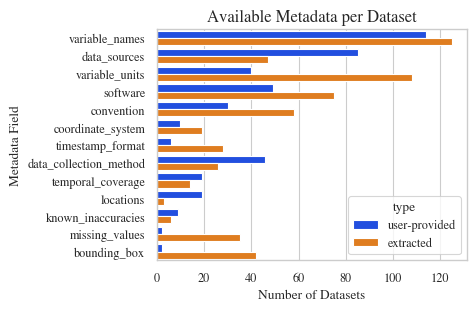

In [42]:
f, ax = plt.subplots(figsize=figsize)
# Reshape the DataFrame
df_long = pd.melt(
    df.groupby("type").count().reset_index(), 
    id_vars=['type'], value_vars=['variable_names', 'data_sources', 'variable_units', 'software',
       'convention', 'coordinate_system', 'timestamp_format', 'data_collection_method',
       "temporal_coverage", 'locations', 'known_inaccuracies', 'missing_values',
       'bounding_box'], var_name='CountType', value_name='Value'
    )

rename_dict = {
    'metadata': 'user-provided',
    'ncml': 'extracted',
    # Add more categories as needed
}

# Step 3: Replace category names
df_long['type'] = df_long['type'].replace(rename_dict)

# Create the plot
sns.barplot(y='CountType', x='Value', hue='type', data=df_long, palette="bright")

ax.set_title("Available Metadata per Dataset", fontsize=12)
ax.set_xlabel("Number of Datasets")
ax.set_ylabel("Metadata Field")

plt.savefig("../results/md-ncml-counts.pdf", bbox_inches="tight")

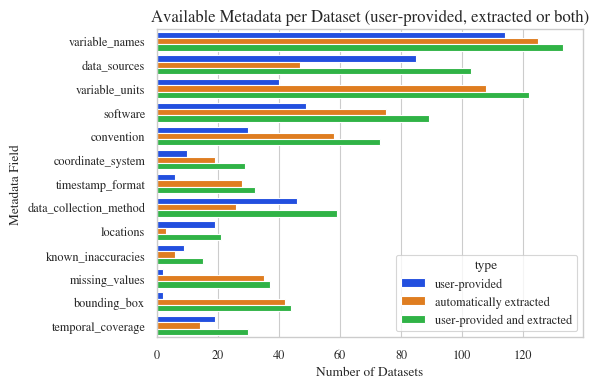

In [43]:
f, ax = plt.subplots(figsize=(5.5, 4)) 

both_ = (df.groupby("id").count()>0).sum(axis=0).reset_index().rename(columns={0: "count"})
md_vals = df[df.type == "metadata"].count().reset_index().rename(columns={0: "count"})
ncml_vals = df[df.type == "ncml"].count().reset_index().rename(columns={0: "count"})

both_ = both_[~both_['index'].isin(['id','type'])]
md_vals = md_vals[~md_vals['index'].isin(['id','type'])]
ncml_vals = ncml_vals[~ncml_vals['index'].isin(['id','type'])]

both_["type"] = "user-provided and extracted"
md_vals["type"] = "user-provided"
ncml_vals["type"] = "automatically extracted"

sns.barplot(y='index', x='count', hue='type', 
            data=pd.concat([ md_vals, ncml_vals, both_], axis=0),
            palette="bright")

plt.xlabel("Number of Datasets")
plt.ylabel("Metadata Field")
plt.title("Available Metadata per Dataset (user-provided, extracted or both)", fontsize=12)

plt.savefig("../results/additional-ncml3.pdf", bbox_inches="tight")

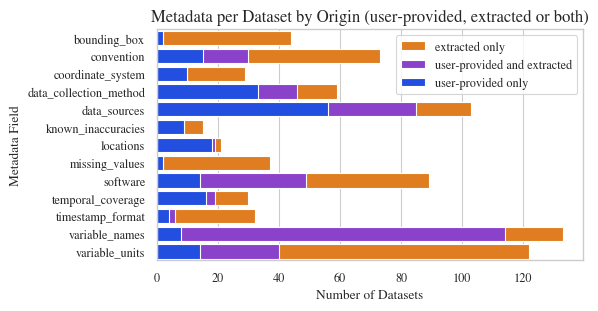

In [44]:
f, ax = plt.subplots(figsize=(5.5, 3)) 

both_ = (df.groupby("id").count()==2).sum(axis=0)
none_ = (df.groupby("id").count()==0).sum(axis=0)

md_vals = df[df.type == "metadata"].count() - both_
ncml_vals = df[df.type == "ncml"].count() - both_

# For drawing
both_ = both_+md_vals
ncml_vals = ncml_vals+both_

both_ = both_.reset_index().rename(columns={0: "count"})
md_vals = md_vals.reset_index().rename(columns={0: "count"})
ncml_vals = ncml_vals.reset_index().rename(columns={0: "count"})
none_ = none_.reset_index().rename(columns={0: "count"})

both_ = both_[~both_['index'].isin(['id','type'])]
md_vals = md_vals[~md_vals['index'].isin(['id','type'])]
ncml_vals = ncml_vals[~ncml_vals['index'].isin(['id','type'])]
none_ = none_[~none_['index'].isin(['id','type'])]

palette = sns.color_palette("bright")


plt3 = sns.barplot(x = 'count', y = 'index', data = ncml_vals, label = "extracted only", color = palette[1])
plt2 = sns.barplot(x = 'count', y = 'index', data = both_, label = "user-provided and extracted", color = palette[4])
plt1 = sns.barplot(x = 'count', y='index', data = md_vals, label = "user-provided only", color = palette[0])
#plt4 = sns.barplot(x = 'count', y = 'index', data = none_, label = "none", color = palette[6])=

plt.xlabel("Number of Datasets")
plt.ylabel("Metadata Field")
plt.title("Metadata per Dataset by Origin (user-provided, extracted or both)", fontsize=12)

plt.savefig("../results/additional-ncml2.pdf", bbox_inches="tight")

In [45]:
both_ = (df.groupby("id").count()==2).sum(axis=0)
ncml_vals = df[df.type == "ncml"].count() - both_

ncml_vals

bounding_box              42.0
convention                43.0
coordinate_system         19.0
data_collection_method    13.0
data_sources              18.0
id                         NaN
known_inaccuracies         6.0
locations                  2.0
missing_values            35.0
software                  40.0
temporal_coverage         11.0
timestamp_format          26.0
type                       0.0
variable_names            19.0
variable_units            82.0
dtype: float64

In [46]:
ncml_vals.mean()

25.428571428571427

In [47]:
25/134

0.1865671641791045

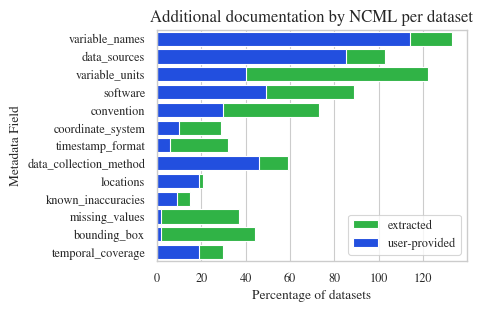

In [48]:
f, ax = plt.subplots(figsize=figsize)

# Datasets with both md and ncml values
md_and_ncml_vals = df.groupby("id").count().reset_index().astype(bool).sum(axis=0).reset_index().rename(columns={0: "count"})
# Datasets with only md values
md_vals = df[df.type == "metadata"].count().reset_index().rename(columns={0: "count"})

#md_and_ncml_vals['count'] = md_and_ncml_vals['count']*100/len(metadata_df)
#md_vals['count'] = md_vals['count']*100/len(metadata_df)

# Minor cleaning
md_vals = md_vals[~md_vals['index'].isin(['id','type'])]
md_and_ncml_vals = md_and_ncml_vals[~md_and_ncml_vals['index'].isin(['id','type'])]

palette = sns.color_palette("bright")
plt1 = sns.barplot(x = 'count', y='index', data = md_and_ncml_vals, label = "extracted", color = palette[2])
plt2 = sns.barplot(x = 'count', y = 'index', data = md_vals, label = "user-provided", color = palette[0])

plt.xlabel("Percentage of datasets")
plt.ylabel("Metadata Field")
plt.title("Additional documentation by NCML per dataset", fontsize=12)

plt.savefig("../results/additional-ncml.pdf", bbox_inches="tight")

In [49]:
df_diff = md_and_ncml_vals.join(md_vals.set_index('index'), on='index', lsuffix='_ncml', rsuffix='_metadata')
df_diff['diff'] = df_diff['count_ncml'] - df_diff['count_metadata']
df_diff

,index,count_ncml,count_metadata,diff
1,variable_names,133,114,19
2,data_sources,103,85,18
3,variable_units,122,40,82
4,software,89,49,40
5,convention,73,30,43
6,coordinate_system,29,10,19
7,timestamp_format,32,6,26
8,data_collection_method,59,46,13
9,locations,21,19,2
10,known_inaccuracies,15,9,6


In [50]:
df_diff['diff'].mean()

27.384615384615383

In [51]:
df_diff['diff'].mean()*100/len(metadata_df)

20.436280137772673

/var/folders/lc/q1l1y0k176b0h_m5yz0s_r5w0000gn/T/ipykernel_48762/1184800438.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['variable_names'] = df['variable_names'].fillna(0).astype(int)
/var/folders/lc/q1l1y0k176b0h_m5yz0s_r5w0000gn/T/ipykernel_48762/1184800438.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['variable_units'] = df['variable_units'].fillna(0).astype(int)


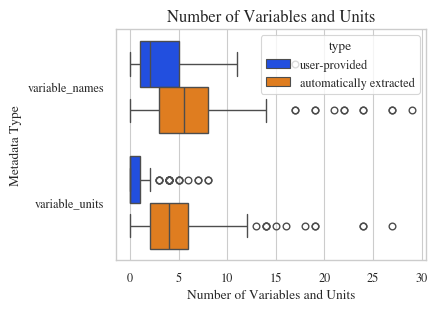

In [52]:
f, ax = plt.subplots(figsize=figsize)

df['variable_names'] = df['variable_names'].fillna(0).astype(int)
df['variable_units'] = df['variable_units'].fillna(0).astype(int)
df['type'] = df['type'].replace({"metadata": "user-provided", "ncml": "automatically extracted"})

sns.boxplot(pd.melt(
    df, 
    id_vars=['type'], value_vars=['variable_names','variable_units'], var_name='CountType', value_name='Value', 
    ), y='CountType', x='Value', hue='type', palette="bright")

ax.set_title("Number of Variables and Units", fontsize=12)
ax.set_xlabel("Number of Variables and Units")
ax.set_ylabel("Metadata Type")

plt.savefig("../results/var_units_diff.pdf", bbox_inches="tight")

## Next Steps

In [53]:
df.columns

Index(['variable_names', 'data_sources', 'variable_units', 'software',
       'convention', 'coordinate_system', 'timestamp_format',
       'data_collection_method', 'locations', 'known_inaccuracies',
       'missing_values', 'id', 'type', 'bounding_box', 'temporal_coverage'],
      dtype='object')

In [54]:

# df.locations.value_counts() - OK
# 'timestamp_format', - OK

# df.time_frequency.value_counts() - OK; ncml should be superior
# df.spatial_resolution.value_counts() - OK; ncml should be superior
# 20020202

# 'known_inaccuracies', 'missing_values' - TODO; separate

# 'data_sources', - paper, simulation, observation, model, satellite, -- comment
#    'data_collection_method', - TODO

# 'variable_units', 
# 'software' -- comment

In [55]:
# df.locations -- OK locations -- comment
# compare bounding_box and locations ?

In [56]:
# unknown => None
# netcdf is maybe a package?



df.software.value_counts()

software
netcdf=4.6.2, hdf5=1.10.4                                                                          9
NetCDF Markup Language                                                                             3
Python v3.8                                                                                        2
Aqua granule hdf                                                                                   2
version=2, netcdf=4.6.2, hdf5=1.10.4                                                               2
                                                                                                  ..
Model output for Dutkiewicz et al (BGD): nurtient_supply_rates.nc, biomass.nc                      1
Vulcan version 3.0, gridded inventory of CH4 emissions                                             1
WACCM, Reproducing_Figures_Linzetal2021_AoA.m                                                      1
Gaofen5, ZY1, PRISMA                                                              

In [57]:
df.data_collection_method.value_counts()

# unspecified => None
# Created Thu Nov 4 10:56:49 2021  => None

data_collection_method
Aqua satellite, MODIS Collection 6.1                                                                                                           12
Satellite                                                                                                                                       6
sensor readings                                                                                                                                 3
satellite                                                                                                                                       2
ship-track                                                                                                                                      2
Derived from granule name                                                                                                                       2
McLane moored profiler (MP) data                                                                     

In [58]:
df.groupby('type').count()

,variable_names,data_sources,variable_units,software,convention,coordinate_system,timestamp_format,data_collection_method,locations,known_inaccuracies,missing_values,id,bounding_box,temporal_coverage
type,,,,,,,,,,,,,,
automatically extracted,134,47,134,75,58,19,28,26,3,6,35,134,42,14
user-provided,134,85,134,49,30,10,6,46,19,9,2,134,2,19


In [59]:
a = "data_collection_method"

df[df[a].notnull()][[a, "id"]].sort_values(by='id')

,data_collection_method,id
10,"sensor readings, satellite",2842848
73,Model,2904219
60,NovAtel SPAN GPS/INS,3101967
46,model analysis,3138707
75,Bootstrapping,3349351
...,...,...
26,Model experiments,6930719
41,Satellite observation,6951241
16,Simulated,6987648
116,Simulation,7017644
